In [37]:
#!pip install tldextract catboost

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import numpy as np
import pandas as pd
import re
import joblib
import torch
from PIL import Image
from torchvision import transforms
from urllib.parse import urlparse
import tldextract
import torch
import torch.nn.functional as F
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [40]:
class FusionModel:
    def __init__(self, models, tfid, bert_model, tokenizer, f1_weights, device):
        self.models = models
        self.tfid = tfid
        self.bert_model = bert_model
        self.tokenizer = tokenizer
        self.f1_weights = f1_weights
        self.device = device

    def predict_proba(self, texts):
        model_probs = []

        # Traditional models
        tfidf_vec = self.tfid.transform(texts)
        for name in self.models:
            probs = self.models[name].predict_proba(tfidf_vec)[:, 1]
            model_probs.append(probs)

        # BERT
        self.bert_model.eval()
        bert_probs = []
        with torch.no_grad():
            for i in range(0, len(texts), 16):
                batch = texts[i:i+16]
                inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(self.device)
                logits = self.bert_model(**inputs).logits
                probs = torch.softmax(logits, dim=1)[:, 1]
                bert_probs.extend(probs.cpu().numpy())
        model_probs.append(np.array(bert_probs))

        # Weighted soft voting
        weights = np.array(list(self.f1_weights.values())).reshape(-1, 1)
        all_probs = np.array(model_probs)
        return np.sum(all_probs * weights, axis=0) / np.sum(weights)

    def predict(self, texts):
        probs = self.predict_proba(texts)
        return (probs >= 0.5).astype(int)

In [41]:
class URLFusionModel:
    def __init__(self, traditional_models, cnn_model, bert_model, tokenizer, scaler, f1_weights, device, max_length=100):
        self.models = traditional_models
        self.cnn_model = cnn_model
        self.bert_model = bert_model
        self.tokenizer = tokenizer
        self.scaler = scaler
        self.f1_weights = f1_weights
        self.device = device
        self.max_length = max_length

    def _extract_url_features(self, urls):

        features = []
        for url in urls:
            parsed_url = urlparse(url)
            domain_info = tldextract.extract(url)
            features.append([
                len(url),
                len(parsed_url.netloc),
                len(parsed_url.path),
                url.count('.'),
                url.count('-'),
                url.count('/'),
                url.count('?'),
                url.count('&'),
                url.count('='),
                1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0,
                1 if domain_info.suffix in ["xyz", "tk", "ml", "ga", "cf"] else 0
            ])

        feature_names = [
            "length_url", "length_hostname", "length_path", "nb_dots", "nb_hyphens",
            "nb_slash", "nb_qm", "nb_and", "nb_eq", "has_ip_address", "suspicious_tld"
        ]

        scaled = self.scaler.transform(features)
        return pd.DataFrame(scaled, columns=feature_names)

    def _convert_to_seq(self, urls):
        seqs = [[min(ord(char), 255) for char in url[:self.max_length]] for url in urls]
        return pad_sequences(seqs, maxlen=self.max_length, padding='post', truncating='post')

    def predict_proba(self, urls):
        ml_features = self._extract_url_features(urls)
        seq_features = self._convert_to_seq(urls)

        model_probs = []

        for name, model in self.models.items():
            probs = model.predict_proba(ml_features)[:, 1]
            model_probs.append(probs)

        cnn_probs = self.cnn_model.predict(seq_features).flatten()
        model_probs.append(cnn_probs)

        self.bert_model.eval()
        bert_probs = []
        with torch.no_grad():
            for i in range(0, len(urls), 16):
                batch = urls[i:i+16]
                inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(self.device)
                logits = self.bert_model(**inputs).logits
                probs = torch.softmax(logits, dim=1)[:, 1]
                bert_probs.extend(probs.cpu().numpy())
        model_probs.append(np.array(bert_probs))

        weights = np.array(list(self.f1_weights.values())).reshape(-1, 1)
        all_probs = np.array(model_probs)
        return np.sum(all_probs * weights, axis=0) / np.sum(weights)

    def predict(self, urls, threshold=0.5):
        probs = self.predict_proba(urls)
        return (probs >= threshold).astype(int)

In [42]:
class ImageFusionWrapper:
    def __init__(self, model_paths, f1_scores, device):
        from torchvision.models import resnet50, efficientnet_b0, densenet121
        from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, DenseNet121_Weights
        import torch.nn as nn

        self.device = device
        self.f1_scores = f1_scores
        self.weights = [f / sum(f1_scores) for f in f1_scores]

        # Load models from paths
        self.models = []

        # ResNet50
        model_res = resnet50(weights=None)
        model_res.fc = nn.Linear(model_res.fc.in_features, 2)
        model_res.load_state_dict(torch.load(model_paths[0], map_location=device))
        model_res.to(device).eval()
        self.models.append(model_res)

        # EfficientNet-B0
        model_eff = efficientnet_b0(weights=None)
        model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 2)
        model_eff.load_state_dict(torch.load(model_paths[1], map_location=device))
        model_eff.to(device).eval()
        self.models.append(model_eff)

        # DenseNet121
        model_den = densenet121(weights=None)
        model_den.classifier = nn.Linear(model_den.classifier.in_features, 2)
        model_den.load_state_dict(torch.load(model_paths[2], map_location=device))
        model_den.to(device).eval()
        self.models.append(model_den)

    def predict(self, dataloader):
        all_preds = []
        with torch.no_grad():
            for inputs in dataloader:
                if isinstance(inputs, (tuple, list)):
                    inputs = inputs[0]
                inputs = inputs.to(self.device)
                probs = [F.softmax(m(inputs), dim=1) for m in self.models]
                avg_prob = sum(w * p for w, p in zip(self.weights, probs))
                preds = torch.argmax(avg_prob, dim=1)
                all_preds.extend(preds.cpu().numpy())
        return all_preds

In [43]:
email_model_path = "/content/drive/My Drive/Phishing_Models/fusion_model_email.pkl"
url_model_path = "/content/drive/My Drive/Phishing_Models/fusion_model_url.pkl"
image_model_path = "/content/drive/My Drive/Phishing_Models/image_fusion_model.pkl"


fusion_model = joblib.load(email_model_path)
fusion_url_model_obj = joblib.load(url_model_path)
fusion_image_model = joblib.load(image_model_path)

In [44]:
def is_valid_image_tensor(image_tensor):
    return (
        isinstance(image_tensor, torch.Tensor)
        and image_tensor.shape == (3, 224, 224)
        and torch.any(image_tensor)
    )

In [45]:
# === Cell 1 ===

class MultimodalPhishingDetector:
    def __init__(self, email_model, url_model, image_model):
        self.email_model = email_model
        self.url_model = url_model
        self.image_model = image_model

    def predict_proba(self, email_text=None, url=None, image_tensor=None):
        """
        Get phishing probability from email, URL, or both.
        :return: dict with phishing probabilities
        """
        email_prob = None
        url_prob = None
        image_prob = None

        if email_text:
            email_prob = self.email_model.predict_proba([email_text])[0]
        if url:
            url_prob = self.url_model.predict_proba([url])[0]

        image_prob = None
        if image_tensor is not None and is_valid_image_tensor(image_tensor):
            image_tensor = image_tensor.unsqueeze(0)
            dummy_loader = [(image_tensor,)]
            image_pred = self.image_model.predict(dummy_loader)
            image_prob = 1.0 if image_pred[0] == 1 else 0.0

        if email_prob is None and url_prob is None and image_prob is None:
            raise ValueError("Provide at least `email_text` or `url` or 'image'.")

        return {
            "email_prob": email_prob,
            "url_prob": url_prob,
            "image_prob": image_prob
        }

    def predict(self, email_text=None, url=None, image_tensor=None, threshold=0.5, return_prob=False):
      probs = self.predict_proba(email_text=email_text, url=url, image_tensor=image_tensor)

      email_prob = probs.get("email_prob")
      url_prob = probs.get("url_prob")
      image_prob = probs.get("image_prob")

      inputs_used = [p for p in [email_prob, url_prob, image_prob] if p is not None]

      # 🛑 If no inputs are provided
      if not inputs_used:
          if return_prob:
              return None, None, email_prob, url_prob, image_prob
          else:
              return None

      # ✅ If any one input says phishing
      label = 1 if any(p >= threshold for p in inputs_used) else 0
      final_prob = max(inputs_used)

      if return_prob:
          return label, final_prob, email_prob, url_prob, image_prob
      else:
          return label

In [46]:
multi_model = MultimodalPhishingDetector(
    email_model=fusion_model,
    url_model=fusion_url_model_obj,
    image_model=fusion_image_model
)

print(f"Image Valid: {is_valid_image_tensor(image_tensor)}")

Image Valid: True


In [63]:
import matplotlib.pyplot as plt

def plot_prediction_probs(email_prob=None, url_prob=None, image_prob=None):
    labels = []
    values = []
    colors = []

    if email_prob is not None:
        labels.append("Email")
        values.append(email_prob)
        colors.append("skyblue")

    if url_prob is not None:
        labels.append("URL")
        values.append(url_prob)
        colors.append("orange")

    if image_prob is not None:
        labels.append("Image")
        values.append(image_prob)
        colors.append("green")

    if not values:
        print("⚠️ No valid inputs to visualize.")
        return

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=colors)
    plt.axhline(0.5, color='red', linestyle='--', label="Phishing Threshold (0.5)")
    plt.title("Prediction Confidence per Modality")
    plt.ylim(0, 1)
    plt.ylabel("Probability (0 = Safe, 1 = Phishing)")
    plt.legend()
    plt.grid(True, axis='y')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [64]:
def test_multimodal_input(multi_model, email_text=None, url=None, image_tensor=None, threshold=0.5):
    """
    Predict phishing using any combination of email, URL, and image.
    Shows final label and individual confidence scores.
    """
    # ✅ Check if image is valid before using
    image_valid = is_valid_image_tensor(image_tensor)
    image_tensor_to_use = image_tensor if image_valid else None

    # Perform prediction
    label, final_prob, email_prob, url_prob, image_prob = multi_model.predict(
        email_text=email_text,
        url=url,
        image_tensor=image_tensor_to_use,
        threshold=threshold,
        return_prob=True
    )

    # Determine input type used
    used = []
    if email_text: used.append("EMAIL")
    if url: used.append("URL")
    if image_valid: used.append("IMAGE")
    input_type = " + ".join(used)

    # === Final Overall Result ===
    if label is None:
        print("\n⚠️ No input provided. Please provide at least an email, URL, or image.")
        return

    # === Final Overall Result ===
    status = "PHISHING" if label == 1 else "SAFE"
    print(f"\n🔎 [{input_type}] ➤ Final Prediction: {status} (Final Confidence: {final_prob:.4f})")

    # === Per Modality Breakdown ===
    if email_prob is not None:
        email_status = "Phishing" if email_prob >= threshold else "Safe"
        print(f"   - 📧 Email:  {email_status} (Confidence: {email_prob:.4f})")

    if url_prob is not None:
        url_status = "Phishing" if url_prob >= threshold else "Safe"
        print(f"   - 🔗 URL:    {url_status} (Confidence: {url_prob:.4f})")

    if image_valid:
        image_status = "Phishing" if image_prob == 1.0 else "Safe"
        print(f"   - 🖼️ Image:  {image_status} (Prediction: {int(image_prob)})")

    plot_prediction_probs(email_prob=email_prob, url_prob=url_prob, image_prob=image_prob)

In [65]:
def load_image_tensor(img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    return transform(image)





Image Valid: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔎 [EMAIL + URL + IMAGE] ➤ Final Prediction: PHISHING (Final Confidence: 1.0000)
   - 📧 Email:  Safe (Confidence: 0.1411)
   - 🔗 URL:    Safe (Confidence: 0.0989)
   - 🖼️ Image:  Phishing (Prediction: 1)


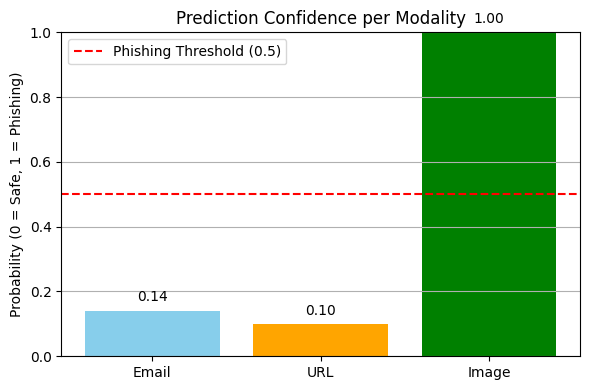

In [67]:
image_tensor = None  # Clear old image
print(f"Image Valid: {is_valid_image_tensor(image_tensor)}")
#image_tensor = load_image_tensor("/content/amazon (4).png")
test_multimodal_input(
    multi_model,
    email_text="hi your meeting is scheduled",
    url="http://www.amazon.com",
    image_tensor=image_tensor
)